# <font color=4CBB17>**Preprocesamiento**</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tensorflow

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.utils import to_categorical  # convertir etiquetas a one-hot encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import itertools

In [ ]:

base_skin_dir = os.path.join('..', 'input')

# Fusionar imágenes de ambas carpetas HAM10000_images_part1.zip y HAM10000_images_part2.zip en un diccionario

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Se usa un diccionario para poner los nombres completos a cada abreviatura
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
import zipfile
import os

# Ruta al archivo zip en Google Drive
zip_path1 = '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_images_part_1.zip'
zip_path2 = '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_images_part_2.zip'

# Carpeta destino donde se extraerán las imágenes
extract_to = '/content/ham10000_images'

# Crear carpeta si no existe, si ya existe, no lanza error
os.makedirs(extract_to, exist_ok=True)

# Extraer archivos
with zipfile.ZipFile(zip_path1, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
#glob permite buscar archivos que coincidan con un patrón, como *.jpg
from glob import glob

base_skin_dir = extract_to  # ahora apunta a '/content/ham10000_images'

# Diccionario por comprensión que mapea cada nombre de imagen (sin extensión jpg) a su ruta completa en base_skin_dir
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*.jpg'))
}

In [ ]:
import os

# Ruta al csv en Google Drive
csv_path = '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_metadata.csv'

# Leer el archivo csv
skin_df = pd.read_csv(csv_path)

# Verificar los primeros registros
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
skin_df['localization'].value_counts()

,count
localization,
back,2192
lower extremity,2077
trunk,1404
upper extremity,1118
abdomen,1022
face,745
chest,407
foot,319
unknown,234


In [ ]:
# Se crea una columna con la ruta completa de cada imagen y otra con el nombre completo del tipo de lesión a partir de su abreviación

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)


In [ ]:
# Lista ordenada con los nombres únicos de los tipos de lesión en la columna cell_type
categorias = pd.Categorical(skin_df['cell_type']).categories
categorias

Index(['Actinic keratoses', 'Basal cell carcinoma',
       'Benign keratosis-like lesions ', 'Dermatofibroma', 'Melanocytic nevi',
       'Melanoma', 'Vascular lesions'],
      dtype='object')

In [ ]:
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes # El número se asigna de acuerdo con el orden en que aparece arriba,
                                                                      # .codes lo que hace es devolver un array de enteros que representa
                                                                      # a cada categoría como un número

In [ ]:
# Se verifican las 3 columnas creadas
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [45]:
skin_df['dx_type'].value_counts()

,count
dx_type,
histo,5340
follow_up,3704
consensus,902
confocal,69


In [ ]:
skin_df.isnull().sum()


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [ ]:
# Reemplaza los valores nulos de la columna age del df por el valor promedio de esa columna
skin_df['age'] = skin_df['age'].fillna(skin_df['age'].mean())

In [ ]:
skin_df.isnull().sum()


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [ ]:
print(skin_df.dtypes)


lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


Realizar exploración

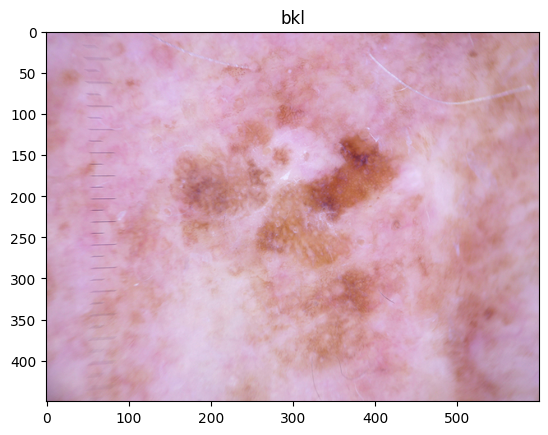

In [38]:
import cv2
import matplotlib.pyplot as plt

# Obtener la ruta de la imagen
ruta_imagen = skin_df.loc[skin_df['image_id'] == 'ISIC_0027419', 'path'].values[0]

# Leer la imagen con OpenCV (en BGR)
img_cv2 = cv2.imread(ruta_imagen)

# Convertir a RGB para mostrarla correctamente con matplotlib
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Mostrarla
plt.imshow(img_rgb)
plt.title('bkl')
plt.show()

In [39]:
img_rgb.shape

(450, 600, 3)

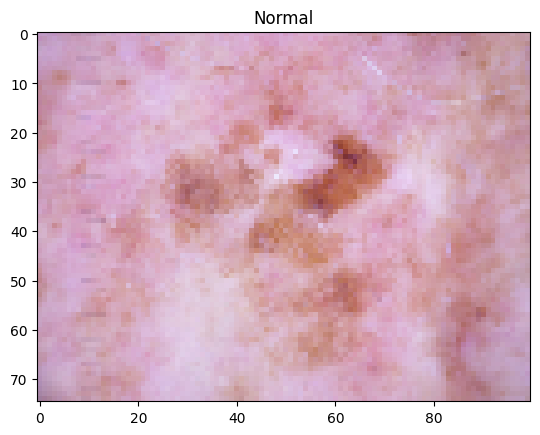

np.int64(22500)

In [42]:
img2_r = cv2.resize(img_rgb ,(100,75))
plt.imshow(img2_r)
plt.title('Normal')
plt.show()
np.prod(img2_r.shape)


Se va a redimensionar las imagenes 100 x 75 ya que es nos ofrece una buena calidad al estar limitados de recursos.

In [43]:
# Crear una nueva columna que contiene la imagen en forma de array redimensionada
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


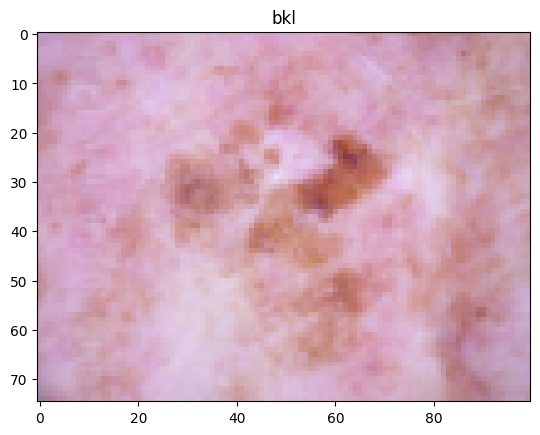

In [ ]:
# Número de muestras por clase que se van a mostrar
n_samples = 5

# Se crea una figura con subplots de 7 filas, una por tipo de lesión 5 columnas
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))

# Se recorren simultáneamente los ejes de cada fila n_axs y los grupos del df según el cell_type
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):

    # Se coloca el nombre del tipo de lesión (cell_type) como título del primer gráfico de la fila
    n_axs[0].set_title(type_name)

    # Para cada eje (c_ax) y fila del grupo correspondiente (tipo de lesión), se seleccionan n_samples aleatorios
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off') # Se ocultan ejes

# Se guarda la figura generada como una imagen en disco
fig.savefig('category_samples.png', dpi=200)

Output hidden; open in https://colab.research.google.com to view.

In [44]:
# Se revisa la imagen para confirmar cada dimensión (alto, ancho, canales)

skin_df['image'].map(lambda x: x.shape).value_counts()


,count
image,
"(75, 100, 3)",10015


In [50]:
x=skin_df.drop(columns=['cell_type_idx'],axis=1)
y=skin_df['cell_type_idx']

In [52]:
#Para un Random Forest o XGBoost (imágenes + datos tabulares)
from sklearn.preprocessing import MinMaxScaler


# 1. Procesar variables tabulares
X_tab = skin_df[['age', 'sex', 'localization']].copy()

# Escalar 'age'
scaler = MinMaxScaler()
X_tab['age'] = scaler.fit_transform(X_tab[['age']])

# One-hot encoding para variables categóricas
X_tab = pd.get_dummies(X_tab, columns=['sex', 'localization'], drop_first=True)

# 2. Aplanar imágenes
X_img_flat = np.stack(skin_df['image'].values)            # (n, 100, 75, 3)
X_img_flat = X_img_flat.reshape(X_img_flat.shape[0], -1)  # (n, 22500)

# 3. Concatenar imagen y datos tabulares
X_rf = np.concatenate([X_img_flat, X_tab.values], axis=1)
y_rf = y.copy()

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.20,random_state=123)

In [57]:
# Imágenes en formato (n_samples, alto, ancho, canales)
X_cnn = np.stack(skin_df['image'].values)

# Etiquetas
y_cnn = skin_df['cell_type_idx'].values

In [58]:
X_cnn = X_cnn / 255.0

In [59]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y_cnn, test_size=0.20, random_state=123, stratify=y_cnn
)

In [63]:
import joblib

output_path = '/content/drive/MyDrive/cod/LEA3_health_7/salidas'
os.makedirs(output_path, exist_ok=True)

# Guardar archivos correctamente
joblib.dump(x_train, f"{output_path}/x_train.pkl")
joblib.dump(x_test, f"{output_path}/x_test.pkl")
joblib.dump(y_train, f"{output_path}/y_train.pkl")
joblib.dump(y_test, f"{output_path}/y_test.pkl")

joblib.dump(X_train_cnn, f"{output_path}/X_train_cnn.pkl")
joblib.dump(y_train_cnn, f"{output_path}/y_train_cnn.pkl")
joblib.dump(X_test_cnn, f"{output_path}/X_test_cnn.pkl")
joblib.dump(y_test_cnn, f"{output_path}/y_test_cnn.pkl")

['/content/drive/MyDrive/cod/LEA3_health_7/salidas/y_test_cnn.pkl']